In [41]:
import os
import numpy as np
import time
import phate
import copy

import seaborn as sns
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
#%matplotlib inline
#np.random.seed(0)

In [42]:
def get_continual_month_data(data_dir, month, train=True):
    
    if train:
        data_dir = data_dir + str(month) + '/'
        XY_train = np.load(data_dir + 'XY_train.npz')
        X_tr, Y_tr = XY_train['X_train'], XY_train['Y_train']

        return X_tr, Y_tr
    else:
        data_dir = data_dir + str(month) + '/'
        XY_test = np.load(data_dir + 'XY_test.npz')
        X_test, Y_test = XY_test['X_test'], XY_test['Y_test']

        return X_test, Y_test 


def get_task_continual_test_data(data_dir, current_task):
    
    X_te, Y_test = get_continual_month_data(data_dir, current_task, train=False)
    
    X_test = []
    for i in X_te: #make 2381 to 2401 so that the sqrt is 49
        i = np.array(list(i) + [0] * 20)
        X_test.append(i)

    X_test = np.float32(np.array(X_test))
    #X_test, Y_test = shuffle(X_test, Y_test)
    
    print(f'Testing X_test {X_test.shape} Y_test {Y_test.shape}')
    
    return X_test, Y_test

def get_task_continual_training_data(data_dir, current_task):
    
    X_tr, Y_train = get_continual_month_data(data_dir, current_task)
    
    X_train = []
    for i in X_tr: #make 2381 to 2401 so that the sqrt is 49
        i = np.array(list(i) + [0] * 20)
        X_train.append(i)
        
    X_train = np.float32(np.array(X_train))
    #X_train, Y_train = shuffle(X_train, Y_train)
    
    print(f'Current Task month training {current_task} data X {X_train.shape} Y {Y_train.shape}')
    return X_train, Y_train


all_task_months = ['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12']

data_dir = '../../../ember2018/month_based_processing/'


standard = True

if standard:
    standardization = StandardScaler()

    
#train_datasets = []
test_datasets = []

num_samples = []



for task_id, current_task in enumerate(all_task_months[:1]):
    #taskid_X_train, taskid_Y_train = get_task_continual_training_data(data_dir, current_task)
    taskid_X_test, taskid_Y_test = get_task_continual_test_data(data_dir, current_task)
    #num_samples.append(len(taskid_Y_train))
    num_samples.append(len(taskid_Y_test))
    
    if standard:
        standard_scaler = standardization.partial_fit(taskid_X_test)
        #taskid_X_train = standard_scaler.transform(taskid_X_train)
        taskid_X_test = standard_scaler.transform(taskid_X_test)
        #taskid_X_train, taskid_Y_train = np.array(taskid_X_train, np.float32), np.array(taskid_Y_train, np.float32)
        taskid_X_test, taskid_Y_test = np.array(taskid_X_test, np.float32), np.array(taskid_Y_test, np.float32)                  

        #train_datasets.append(TransformedDataset((taskid_X_train, taskid_Y_train)))
        #test_datasets.append(TransformedDataset((taskid_X_test, taskid_Y_test)))
        test_datasets.append((taskid_X_test, taskid_Y_test))
    else:
        test_datasets.append((taskid_X_test, taskid_Y_test))

print(f'number of test samples {np.sum(num_samples)}')


x = test_datasets[0][0]
y = test_datasets[0][1]

#if len(test_datasets) > 1:
#    for k in range(1, 12):
#        x_, y_ = test_datasets[k][0], test_datasets[k][1]
#        x, y = np.concatenate((x, x_)), np.concatenate((y, y_))
#
#tsne = TSNE(n_components=2,random_state=123)
#ember_domain_embedded = tsne.fit_transform(x)

Testing X_test (6192, 2401) Y_test (6192,)
number of test samples 6192


In [57]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS, cluster_optics_dbscan
from scipy.spatial.distance import cdist
from sklearn import mixture
from scipy import stats

In [66]:
tsne = TSNE(random_state=123)
ember_domain_embedded = tsne.fit_transform(x)

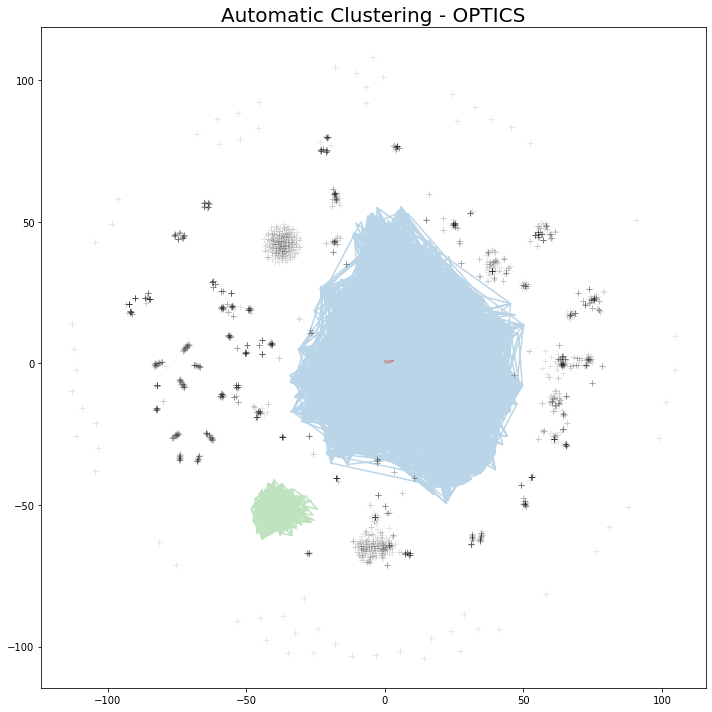

In [71]:
mal_indx = np.where(y==1)
mal_samples = ember_domain_embedded[mal_indx]
mal_labels = y[mal_indx]

X = ember_domain_embedded #mal_samples
labels_true = y #mal_labels

clust = OPTICS(xi=0.05, min_cluster_size=0.05)

# Run the fit
clust.fit(X)


space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

fig, axes = plt.subplots(1, 1, figsize=(10, 10), sharey=True)
saved_figure = 'tsne_optics_mal_good.png'

# OPTICS
#colors = ["g.", "r.", "b.", "y.", "c."]

unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    plt.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
plt.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], "k+", alpha=0.1)
plt.title("Automatic Clustering - OPTICS", fontsize=20)


plt.tight_layout()
plt.savefig('./figures/' + saved_figure);
plt.show()

In [73]:
mal_indx = np.where(y==1)
mal_samples = ember_domain_embedded[mal_indx]
mal_labels = y[mal_indx]

print(len(mal_samples), len(mal_labels))

3264 3264


Estimated number of clusters: 155
Estimated number of noise points: 1620
Homogeneity: 1.00000
Completeness: 0.00000
V-measure: 0.00000
Adjusted Rand Index: 0.00000
Adjusted Mutual Information: 0.00000
Silhouette Coefficient: -0.02820


/home/mr6564/anaconda3/envs/PyTorch/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "border" which is no longer supported as of 3.3 and will become an error two minor releases later


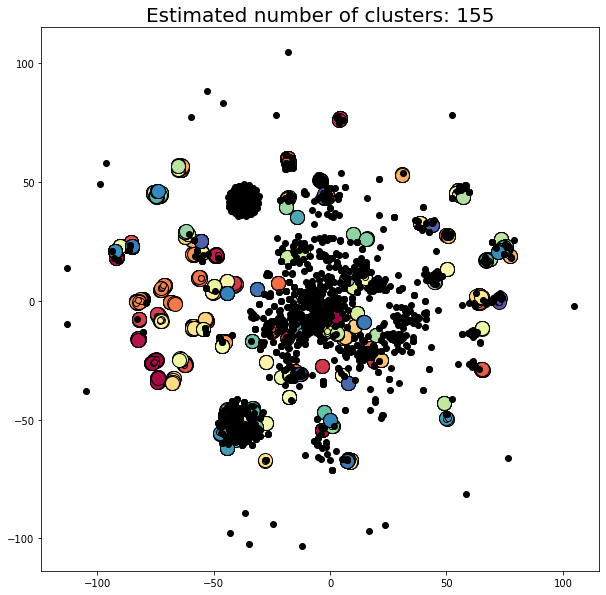

In [74]:
X = mal_samples
labels_true = mal_labels
saved_figure = 'tsne_db_scan_mal.png'

db = DBSCAN(eps=0.5).fit(X)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.5f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.5f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.5f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.5f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.5f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.5f" % metrics.silhouette_score(X, labels))


fig, axes = plt.subplots(1, 1, figsize=(10, 10), sharey=True)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_, fontsize=20)

plt.savefig('./figures/' + saved_figure, border='tight');
plt.show()

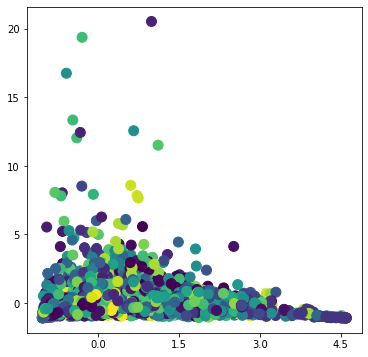

In [17]:
kmeans = KMeans(n_clusters=900, random_state=0)
kmeans.fit(x)

labels = kmeans.predict(x)
fig, axes = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
plt.scatter(x[:, 0], x[:, 1], c=labels, s=100, cmap='viridis');

/home/mr6564/anaconda3/envs/PyTorch/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


ValueError: too many values to unpack (expected 2)

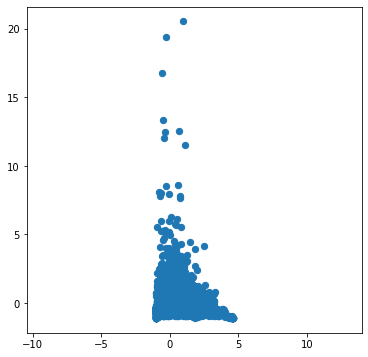

In [8]:



def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)





gmm = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(x)

labels = gmm.predict(x)

fig, axes = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
#plt.scatter(x[:, 0], x[:, 1], c=labels, s=40, cmap='viridis');

plot_gmm(gmm, x, label=False)